In [44]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import random
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [142]:
num_periods = 120
f_horizon = 48
samples = 10020

In [143]:
# data 1 :随机数据
# random.seed(111)
# rng = pd.date_range(start='2000', periods=809, freq='M')
# ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()
# ts.plot(c='b', title='Example Time Series')
# plt.show()
# ts.head(10)

In [144]:
# data 2 : t*sin(t)/3 + 2*sin(5*t)
t = np.linspace(0,100,num=samples)
ts = t*np.sin(t)/3 + 2.*np.sin(5.*t)

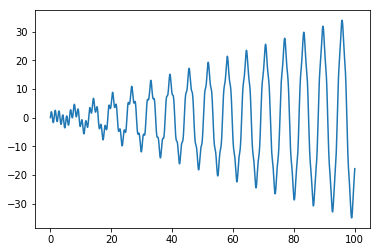

In [145]:
plt.plot(t,ts);

In [146]:
(len(TS)-(len(TS) % num_periods))

9960

In [147]:
(len(TS)-(len(TS) % num_periods)+f_horizon)

10008

In [148]:
TS = np.array(ts)

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
y_data = TS[f_horizon : (len(TS)-(len(TS) % num_periods)+f_horizon)]
print(x_data.shape)
print(y_data.shape)

x_batches = x_data.reshape(-1,num_periods,1)
y_batches = y_data.reshape(-1,num_periods,1)

print(x_batches.shape)

(9960,)
(9960,)
(83, 120, 1)


In [149]:
def test_data(TS, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1,num_periods,1) 
    testY = TS[-(num_periods):].reshape(-1,num_periods,1)
    return testX, testY

In [150]:
X_test, Y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)
print(X_test)

(1, 120, 1)
[[[-24.54312698]
  [-24.73961064]
  [-24.9384413 ]
  [-25.13957923]
  [-25.34297258]
  [-25.54855755]
  [-25.75625844]
  [-25.96598783]
  [-26.17764675]
  [-26.39112487]
  [-26.60630073]
  [-26.82304202]
  [-27.04120585]
  [-27.26063908]
  [-27.48117864]
  [-27.70265191]
  [-27.92487712]
  [-28.14766375]
  [-28.37081295]
  [-28.59411806]
  [-28.817365  ]
  [-29.04033286]
  [-29.26279434]
  [-29.48451633]
  [-29.70526041]
  [-29.92478348]
  [-30.14283827]
  [-30.35917395]
  [-30.57353672]
  [-30.78567043]
  [-30.99531714]
  [-31.2022178 ]
  [-31.40611282]
  [-31.6067427 ]
  [-31.80384867]
  [-31.99717325]
  [-32.18646096]
  [-32.37145886]
  [-32.55191715]
  [-32.72758985]
  [-32.89823529]
  [-33.06361675]
  [-33.22350305]
  [-33.37766902]
  [-33.52589613]
  [-33.66797297]
  [-33.80369578]
  [-33.93286891]
  [-34.05530534]
  [-34.17082708]
  [-34.27926564]
  [-34.3804624 ]
  [-34.47426903]
  [-34.56054782]
  [-34.63917201]
  [-34.71002612]
  [-34.7730062 ]
  [-34.82802011]
  

### rnn cell

In [151]:
tf.reset_default_graph()

learning_rate = 0.001
inputs = 1
hidden = 100
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, status = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

In [152]:
loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [ ]:
epochs = 5000

with tf.Session() as sess:
    sess.run(init)
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X:x_batches, y:y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X:x_batches, y:y_batches})
            print(ep, "  MSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X:X_test})
    print(y_pred)

0   MSE: 2.03148e+06


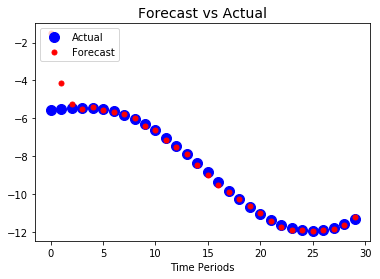

In [129]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'bo', markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), 'r.', markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

###  lstm cell

In [67]:
tf.reset_default_graph()

learning_rate = 0.001
num_periods = 20
inputs = 1
hidden = 100
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

# use lstm here
basic_cell = tf.contrib.rnn.LSTMCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, status = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

In [68]:
loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [69]:
epochs = 5000

with tf.Session() as sess:
    sess.run(init)
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X:x_batches, y:y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X:x_batches, y:y_batches})
            print(ep, "  MSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X:X_test})
    print(y_pred)

0   MSE: 3632.06
100   MSE: 574.685
200   MSE: 204.592
300   MSE: 102.951
400   MSE: 62.0275
500   MSE: 25.0402
600   MSE: 18.7921
700   MSE: 17.8973
800   MSE: 16.6182
900   MSE: 16.06
1000   MSE: 23.5378
1100   MSE: 15.1251
1200   MSE: 14.7116
1300   MSE: 14.3556
1400   MSE: 14.0372
1500   MSE: 17.53
1600   MSE: 13.3933
1700   MSE: 13.4244
1800   MSE: 12.7966
1900   MSE: 12.4948
2000   MSE: 12.2086
2100   MSE: 11.8971
2200   MSE: 11.5997
2300   MSE: 12.0068
2400   MSE: 10.9924
2500   MSE: 12.5569
2600   MSE: 10.3465
2700   MSE: 9.98448
2800   MSE: 9.61153
2900   MSE: 9.19212
3000   MSE: 8.75978
3100   MSE: 8.38472
3200   MSE: 7.83043
3300   MSE: 7.40543
3400   MSE: 6.94755
3500   MSE: 6.65831
3600   MSE: 6.18942
3700   MSE: 5.81822
3800   MSE: 5.5167
3900   MSE: 5.30013
4000   MSE: 4.93602
4100   MSE: 4.7109
4200   MSE: 4.68145
4300   MSE: 4.33006
4400   MSE: 4.18078
4500   MSE: 4.05021
4600   MSE: 3.93367
4700   MSE: 3.8182
4800   MSE: 3.70904
4900   MSE: 3.59513
[[[  8.18803692]
  

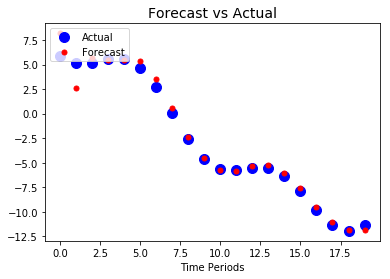

In [70]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'bo', markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), 'r.', markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

### Shapes of variables

In [23]:
rnn_output

<tf.Tensor 'rnn/transpose:0' shape=(?, 20, 100) dtype=float32>

In [24]:
stacked_rnn_output

<tf.Tensor 'Reshape:0' shape=(?, 100) dtype=float32>

In [27]:
stacked_outputs

<tf.Tensor 'dense/BiasAdd:0' shape=(?, 1) dtype=float32>

In [29]:
outputs

<tf.Tensor 'Reshape_1:0' shape=(?, 20, 1) dtype=float32>